In [24]:
#Код выполняется ячейками

import torch #Модуль глубокого обучения PyTorch
import random #Генератор случайных чисел
import numpy as np #Библиотека матриц

#Блокировки генераторов случайных числел в определённой последовательности
#Можно закомментировать, чтобы добавить случайности

#random.seed(0)
#np.random.seed(0)
#torch.manual_seed(0)
#torch.cuda.manual_seed(0)
#torch.backends.cudnn.deterministic = True

In [25]:
import torchvision.datasets #Загрузка датасета MNIST через модуль torchvision
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True) #Загрузка Обучающей выборки
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False) #Загрузка Тестовой выборки

In [26]:
#X данные(изображения цифр) Y метки классов(сама цифра)
#Создаём тензоры данных и меток для тренировочных и тестовых данных
X_train = MNIST_train.train_data 
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [27]:
X_train.dtype, y_train.dtype #Проверка типа данных

(torch.uint8, torch.int64)

In [28]:
X_train = X_train.float() #Перевод тензоров в тип float
X_test = X_test.float()

In [29]:
X_train.shape, X_test.shape #Посмотреть форму тензоров данных
#Первое число - количество изображений
#Второе и третье число - размеры изображения
#Изображения одноканальные

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [30]:
y_train.shape, y_test.shape #Посмотреть форму тензоров меток

(torch.Size([60000]), torch.Size([10000]))

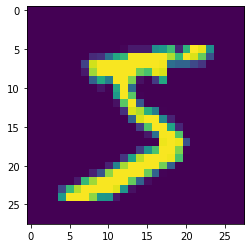

tensor(5)


In [31]:
import matplotlib.pyplot as plt #Вывод примера изображения из датасета с меткой
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [32]:
X_train = X_train.reshape([-1, 28 * 28]) #Преобразование тензоров
X_test = X_test.reshape([-1, 28 * 28]) #Которое растягивает тензор по указаным размерам
# В даннов случае нет необходимости его преобразовывать, но данные могут отличаться

In [33]:
# Создаём саму сеть
#Название класса - название сети
class MNISTNet(torch.nn.Module): #Класс наследуется от torch.nn.Module
    def __init__(self, n_hidden_neurons): #Конструктор класса тут просто прописываются все слои сети
        super(MNISTNet, self).__init__() #это ссылка на конструктор  родительского класса
        # Вникать в классы пока не обязательно
        # Просто перечислить все слои и активации
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons) #Полносвязный слой
        self.ac1 = torch.nn.Sigmoid() # Ф.Активации сигмоида
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) #Выходной слой
        # Стоит обратить внимание, что количество выходных нейронов равно количеству классов
    
    def forward(self, x): #Форвард это порядок в котором будут вызываться слои
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x #Вернуть граф(сеть)
    
mnist_net = MNISTNet(100) # Создаём сеть с 100 скрытыми нейронами

In [34]:
torch.cuda.is_available() #Проверка доступности вычисления на ГПУ
# Если True, то всё хорошо, если False - Среда выполнения,Сменить среду выполнения,GPU

True

In [35]:
!nvidia-smi #Вывести информацию о видеокарте(В колабе это карта сервера)

Wed May 19 04:25:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    36W / 250W |   1361MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
 device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #Выбор видеокарты как исполняющего устройства
 #Если она доступна
 mnist_net = mnist_net.to(device) #Перенос модели(сети) в память видеокарты
 #list(mnist_net.parameters())

In [37]:
loss = torch.nn.CrossEntropyLoss() #Функция потерь(рассчитывает ошибку)
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3) #Оптимизатор(Говорит как делать шаг градиентного спуска)

In [38]:
batch_size = 100 # Размер партии(сколько изображений подаётся из раз сети)

#Создание пустых списков для хранения истории
test_accuracy_history = [] 
test_loss_history = []

#Перенос тестового датасета в память видеокарты
X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(100):#Цикл по эпохам
    order = np.random.permutation(len(X_train)) #Перемешивание примеров в партии
    
    for start_index in range(0, len(X_train), batch_size): #Цикл по примерам в партии
        optimizer.zero_grad() #Обнуление градиента, а то он накапливаться будет
        
        batch_indexes = order[start_index:start_index+batch_size] #Индексы после перемешивания
        
        X_batch = X_train[batch_indexes].to(device) #перенос примеров и меток из партии в 
        y_batch = y_train[batch_indexes].to(device) #Память видеокарты
        
        preds = mnist_net.forward(X_batch) #Получение предсказания сети
        
        loss_value = loss(preds, y_batch) #Расчёт ошибки
        loss_value.backward()#Расчёт градиента, насколько нужно поменять каждый вес 
        
        optimizer.step()#Само изменение веса

    test_preds = mnist_net.forward(X_test) 
    test_loss_history.append(loss(test_preds, y_test)) #Запись истории ошибки(должна уменьшаться)
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean() #Расчёт точности на тесовых данных
    test_accuracy_history.append(accuracy) #Запись истории точности(должна расти)
    print(accuracy) #Выводим точность каждую эпоху

tensor(0.9066, device='cuda:0')
tensor(0.9131, device='cuda:0')
tensor(0.9235, device='cuda:0')
tensor(0.9186, device='cuda:0')
tensor(0.9199, device='cuda:0')
tensor(0.9232, device='cuda:0')
tensor(0.9281, device='cuda:0')
tensor(0.9253, device='cuda:0')
tensor(0.9294, device='cuda:0')
tensor(0.9295, device='cuda:0')
tensor(0.9306, device='cuda:0')
tensor(0.9339, device='cuda:0')
tensor(0.9333, device='cuda:0')
tensor(0.9362, device='cuda:0')
tensor(0.9396, device='cuda:0')
tensor(0.9401, device='cuda:0')
tensor(0.9365, device='cuda:0')
tensor(0.9373, device='cuda:0')
tensor(0.9417, device='cuda:0')
tensor(0.9396, device='cuda:0')
tensor(0.9443, device='cuda:0')
tensor(0.9397, device='cuda:0')
tensor(0.9422, device='cuda:0')
tensor(0.9436, device='cuda:0')
tensor(0.9453, device='cuda:0')
tensor(0.9417, device='cuda:0')
tensor(0.9445, device='cuda:0')
tensor(0.9464, device='cuda:0')
tensor(0.9401, device='cuda:0')
tensor(0.9428, device='cuda:0')
tensor(0.9427, device='cuda:0')
tensor(0

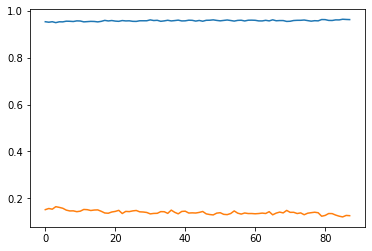

In [23]:
plt.plot(test_accuracy_history) #Строим график точности(растёт)
plt.plot(test_loss_history); #Строим график ошибка(падает)
#Если графики выходят на плато, значит был найден локальный минимум в пространстве весов